In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 100)
pd.set_option("display.width", 120)

url = "https://data.cityofnewyork.us/api/views/6fi9-q3ta/rows.csv?accessType=DOWNLOAD"
df = pd.read_csv(url, sep=",")

In [7]:
df["hour_beginning"] = pd.to_datetime(df["hour_beginning"], errors="coerce")
df["weather_summary"] = df["weather_summary"].fillna("Unknown")
for col in ["Pedestrians", "temperature", "precipitation"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")


df["date"] = df["hour_beginning"].dt.date
df["year"] = df["hour_beginning"].dt.year
df["dow"] = df["hour_beginning"].dt.dayofweek
df["dow_name"] = df["hour_beginning"].dt.day_name()

/tmp/ipython-input-1194711888.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["hour_beginning"] = pd.to_datetime(df["hour_beginning"], errors="coerce")


**1.**

,Weekday,Total Pedestrians
1,Monday,1481435
3,Tuesday,1394963
4,Wednesday,1310900
2,Thursday,1370880
0,Friday,1588068


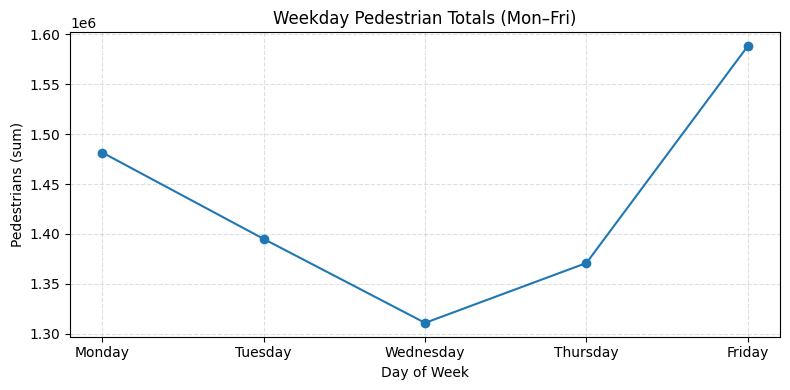

In [8]:
weekdays = df[df["dow"].between(0, 4)].copy()

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
weekday_counts = (weekdays.groupby("dow_name", as_index=False)["Pedestrians"]
                  .sum())
weekday_counts["dow_sort"] = weekday_counts["dow_name"].map({d:i for i,d in enumerate(weekday_order)})
weekday_counts = weekday_counts.sort_values("dow_sort")

display(weekday_counts[["dow_name", "Pedestrians"]].rename(columns={"dow_name":"Weekday", "Pedestrians":"Total Pedestrians"}))

plt.figure(figsize=(8,4))
plt.plot(weekday_counts["dow_name"], weekday_counts["Pedestrians"], marker="o")
plt.title("Weekday Pedestrian Totals (Mon–Fri)")
plt.xlabel("Day of Week")
plt.ylabel("Pedestrians (sum)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

**2.**

,index,weather_summary,Hours,Total_Pedestrians,Avg_Pedestrians
5,5,partly-cloudy-day,1773,2790868,1574.093627
1,1,clear-day,1413,1953025,1382.183298
10,10,wind,4,2716,679.000000
3,3,cloudy,1813,984867,543.225041
7,7,rain,607,139502,229.822076
9,9,snow,38,8460,222.631579
4,4,fog,22,4673,212.409091
8,8,sleet,8,1426,178.250000
6,6,partly-cloudy-night,1209,63794,52.765922
2,2,clear-night,1860,61815,33.233871


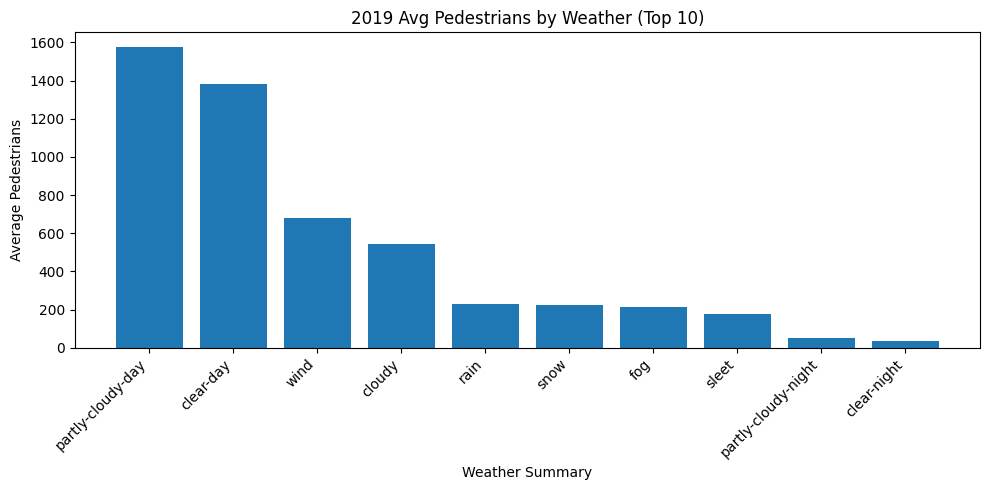

,corr_with_Pedestrians
Pedestrians,1.000000
WX_partly-cloudy-day,0.497867
temperature,0.358757
WX_clear-day,0.339758
WX_wind,-0.000170
WX_sleet,-0.017091
WX_fog,-0.026457
WX_Unknown,-0.030466
WX_snow,-0.034052
WX_cloudy,-0.081255


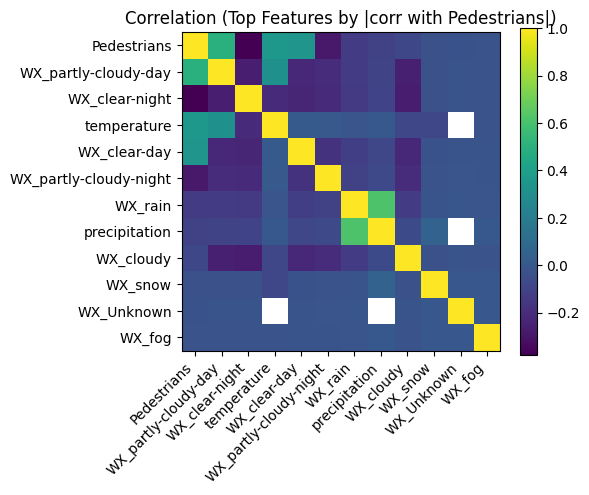

In [9]:
df19 = df[(df["year"] == 2019) & (df["location"] == "Brooklyn Bridge")].copy()

weather_summary_2019 = (df19.groupby("weather_summary", as_index=False)["Pedestrians"]
                        .agg(["count", "sum", "mean"])
                        .reset_index()
                        .rename(columns={"count":"Hours", "sum":"Total_Pedestrians", "mean":"Avg_Pedestrians"}))
weather_summary_2019 = weather_summary_2019.sort_values("Avg_Pedestrians", ascending=False)

display(weather_summary_2019.head(20))

top10 = weather_summary_2019.head(10)
plt.figure(figsize=(10,5))
plt.bar(top10["weather_summary"], top10["Avg_Pedestrians"])
plt.title("2019 Avg Pedestrians by Weather (Top 10)")
plt.xlabel("Weather Summary")
plt.ylabel("Average Pedestrians")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


dummies = pd.get_dummies(df19["weather_summary"], prefix="WX", drop_first=False)
corr_df = pd.concat([df19[["Pedestrians", "temperature", "precipitation"]], dummies], axis=1)

corr = corr_df.corr(numeric_only=True)

ped_corr = corr["Pedestrians"].sort_values(ascending=False)
display(ped_corr.to_frame("corr_with_Pedestrians"))

top_feats = ped_corr.reindex(ped_corr.abs().sort_values(ascending=False).index).index[:12]
heat = corr.loc[top_feats, top_feats]

plt.figure(figsize=(6,5))
plt.imshow(heat, interpolation="nearest")
plt.colorbar()
plt.title("Correlation (Top Features by |corr with Pedestrians|)")
plt.xticks(range(len(top_feats)), top_feats, rotation=45, ha="right")
plt.yticks(range(len(top_feats)), top_feats)
plt.tight_layout()
plt.show()

**3.**

,time_of_day,Pedestrians
0,Afternoon,6803093
2,Morning,2466776
1,Evening,1710794
3,Night,52203


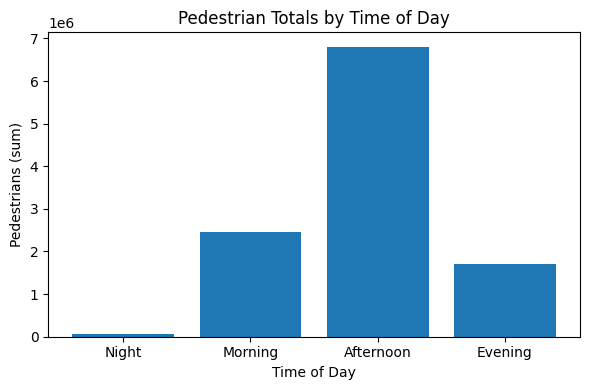

,time_of_day,Avg Pedestrians (2019 BB)
3,Night,5.242812
2,Morning,651.264840
0,Afternoon,1728.908219
1,Evening,359.410046


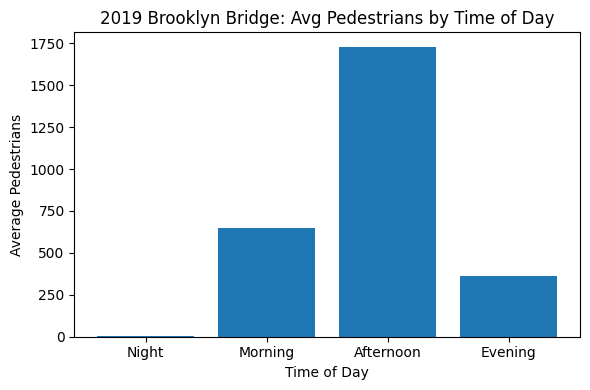

In [10]:
def categorize_time_of_day(ts):
    if pd.isna(ts):
        return np.nan
    hour = ts.hour
    if 0 <= hour <= 5:
        return "Night"
    elif 6 <= hour <= 11:
        return "Morning"
    elif 12 <= hour <= 17:
        return "Afternoon"
    else:
        return "Evening"

df["time_of_day"] = df["hour_beginning"].apply(categorize_time_of_day)

tod_summary = (df.groupby("time_of_day", as_index=False)["Pedestrians"]
               .sum()
               .sort_values("Pedestrians", ascending=False))
display(tod_summary)

tod_order = ["Night", "Morning", "Afternoon", "Evening"]
tod_plot = (df.groupby("time_of_day", as_index=False)["Pedestrians"].sum())
tod_plot["order"] = tod_plot["time_of_day"].map({k:i for i,k in enumerate(tod_order)})
tod_plot = tod_plot.sort_values("order")

plt.figure(figsize=(6,4))
plt.bar(tod_plot["time_of_day"], tod_plot["Pedestrians"])
plt.title("Pedestrian Totals by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Pedestrians (sum)")
plt.tight_layout()
plt.show()

tod_2019_bb = (df19.assign(time_of_day=df19["hour_beginning"].apply(categorize_time_of_day))
               .groupby("time_of_day", as_index=False)["Pedestrians"].mean())
tod_2019_bb["order"] = tod_2019_bb["time_of_day"].map({k:i for i,k in enumerate(tod_order)})
tod_2019_bb = tod_2019_bb.sort_values("order")
display(tod_2019_bb[["time_of_day", "Pedestrians"]].rename(columns={"Pedestrians":"Avg Pedestrians (2019 BB)"}))

plt.figure(figsize=(6,4))
plt.bar(tod_2019_bb["time_of_day"], tod_2019_bb["Pedestrians"])
plt.title("2019 Brooklyn Bridge: Avg Pedestrians by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Average Pedestrians")
plt.tight_layout()
plt.show()